# Investigate temperature change from possible covid-19 responses 

- Use two layer model
- Use emissions from RCMIP



In [1]:
import sys


In [2]:
sys.path.append('/Users/earpmf/PYTHON/twolayermodel/')
sys.path.append('/Users/earpmf/PYTHON/AR6_aerosols/scripts')
print (sys.path)

['/Users/earpmf/OneDrive - University of Leeds/PYTHON/Piers-climate/notebooks', '/Users/earpmf/opt/anaconda3/lib/python37.zip', '/Users/earpmf/opt/anaconda3/lib/python3.7', '/Users/earpmf/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/earpmf/opt/anaconda3/lib/python3.7/site-packages', '/Users/earpmf/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/earpmf/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/earpmf/.ipython', '/Users/earpmf/PYTHON/twolayermodel/', '/Users/earpmf/PYTHON/AR6_aerosols/scripts']


In [3]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import urllib
import json
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import gaussian_kde
from scipy.optimize import root
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from fair.forcing.ghg import etminan
from fair.constants import molwt

import scmpy

In [4]:
etminan([397.547,1831.47,326.99],[284.317,808.25,273.02], scale_F2x=False)

array([1.80197554, 0.55774526, 0.17009249])

In [5]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 10
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
#pl.rcParams['figure.dpi'] = 150

In [6]:
# Should I de-apply rapid adjustments to historical estimates? Climate models from 1850-2014 agree with Etminan with no adjustment

ssp245_allforcing = pd.read_csv('../data/ERF_ssp245_1750-2500.csv')
baseline_forcing = ssp245_allforcing.copy()
baseline_forcing['co2'] = baseline_forcing['co2']/1.05
baseline_forcing['ch4'] = baseline_forcing['ch4']/0.86
baseline_forcing['h2o_stratospheric'] = baseline_forcing['ch4']*0.12
baseline_forcing['land_use'] = baseline_forcing['land_use']/baseline_forcing['land_use'][261]*(-0.15)
baseline_forcing.drop(
    labels=['total_anthropogenic','total'],
    axis='columns',
    inplace=True
)
baseline_forcing['total_anthropogenic'] = baseline_forcing[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-radiation_interactions','aerosol-cloud_interactions']].sum(axis=1)
baseline_forcing['total'] = baseline_forcing['total_anthropogenic'] + baseline_forcing['total_natural']
#baseline_forcing.set_index('year', inplace=True)
pd.set_option('display.max_rows', 999)
#baseline_forcing

In [7]:
#read in other ERFs
url='https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp126_1750-2500.csv'
SSP126_forcing = pd.read_csv(url)
url='https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp460_1750-2500.csv'
SSP460_forcing = pd.read_csv(url)
url='https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp585_1750-2500.csv'
SSP585_forcing = pd.read_csv(url)

In [8]:
SSP245_forcing = baseline_forcing.copy()


# Read in observed tempertures to apply a later constraint#

done
-0.0005179520184544435


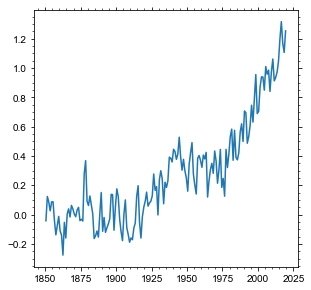

In [9]:
try:
    txt = urllib.request.urlopen('https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt').read()
    cw_flat = np.fromstring(txt, sep=' ')
    cw_nyr = len(cw_flat)//5
    cw_temp = cw_flat.reshape((cw_nyr, 5))
    np.savetxt('../data/obs/CW.txt', cw_temp)
    print('done')
except:
    cw_temp = np.loadtxt('../data/obs/CW.txt')
blratio = np.loadtxt('../data/cmip5_data_2019.txt')[5,:]
cowtan = cw_temp[:,1] - np.mean(cw_temp[:51,1])
years  = cw_temp[:,0]+0.5
blratio  = np.concatenate((np.ones(11), blratio))
Tobs = blratio * cowtan
pl.plot(years, Tobs)
print(np.mean(Tobs[:51]))

In [10]:
#set up a knutii score variable to weight projections later
def rmse(obs, mod):
    return np.sqrt(np.sum((obs-mod)**2)/len(obs))

# we shouldn't really use the Knutti score - it's more for weighting models for projections
def knutti_score(obs, mod):
    """
    obs: observations data: array of size (nyears,)
    mod: model data: array of size (nyears, nsamples)
    """
    samples = mod.shape[1]
    rm_d = np.ones(samples) * np.nan
    rm_s = np.ones((samples, samples)) * np.nan
    for i in range(samples):
        rm_d[i] = rmse(obs, mod[:, i])
#        for j in range(samples):
#            rm_s[i,j] = rmse(mod[:, i], mod[:, j])
    
#    mask = np.ones(rm_s.shape, dtype=bool)
#    np.fill_diagonal(mask, 0)
#    sigma_S = rm_s[mask].min()    
    sigma_D = np.min(rm_d)
#    sigma_S = np.min(rm_s)
    veracity = np.exp(-rm_d**2/sigma_D**2) # (nsamples,)
    similarity = 1 # I see no good reason to change this # 1 + np.sum(np.exp(-rm_s**2/sigma_S**2), axis=1)
    ks_raw = veracity/similarity
    ks = ks_raw/np.sum(ks_raw)
    return ks

In [11]:
with open("../data/cmip6_geoffroy_params.json", "r") as read_file:
    params = json.load(read_file)
#print(-params['q4x']['mean']['EBM-epsilon']/2/params['lamg']['mean']['EBM-epsilon'])

#print (list(params['cdeep']['model_data']['EBM-epsilon'].keys()))
#print (params['cdeep']['model_data']['EBM-1'])
#list(params['eff']['model_data']['EBM-epsilon'].values())

In [12]:
print(params['q4x']['mean']['EBM-epsilon'])
print(params['lamg']['mean']['EBM-epsilon'])
print(params['eff']['mean']['EBM-epsilon'])
print(params['cmix']['mean']['EBM-epsilon'])
print(params['cdeep']['mean']['EBM-epsilon'])
print(params['gamma_2l']['mean']['EBM-epsilon'])
   

7.779135109085985
-1.0634181382332237
1.3412508139190835
8.144224615560551
109.62536045769089
0.6174344256216758


In [13]:

mod_nam = list(params['cdeep']['model_data']['EBM-epsilon'].keys())

mo=['CanESM5', 'CAMS_CSM1_0', 'FGOALS_f3_L', 'ACCESS_CM2', 'GISS_E2_2_G', 'CNRM_ESM2_1', 'GISS_E2_1_H', 
 'GFDL_ESM4', 'SAM0_UNICON', 'IPSL_CM6A_LR', 'AWI_CM_1_1_MR', 'NorESM2_LM', 
 'HadGEM3_GC31_LL', 'GFDL_CM4', 'BCC_CSM2_MR', 'CNRM_CM6_1', 'INM_CM5_0', 'CESM2_WACCM', 'UKESM1_0_LL',
 'MIROC6', 'HadGEM3_GC31_MM', 'E3SM_1_0', 'MRI_ESM2_0', 'MPI_ESM1_2_HR', 'BCC_ESM1', 'GISS_E2_1_G']

# Create an empty list.
lines = []

# Convert lines into string list.
#for line in m:
#    lines.append('out_'+line)
#print(lines)

class CMIP6_SSP245(object):
    pass
class CMIP6_SSP126(object):
    pass
class CMIP6_SSP585(object):
    pass
#for i in mo:
#    setattr(CMIP6_AR5ERF, i, 5)
#CMIP6_AR5ERF.ACCESS_CM2


# Add a samples routine to sample cmip6 models and uncertanity in F
 # Read in SSPemissons #

In [14]:
# fractional uncertainties - based on the FAIR code
samples = 5000   # TODO: change when doing full ensemble run
seed    = 36572 
zscore = st.norm.ppf(0.95)

# can only use published literature - so revert to FaIR and AR5 uncertainties. Use unmodified Etminan for methane, because RFMIP
# models central estimate is quite close.
unc_ranges = np.array([
    0.20,      # CO2
    0.28,      # CH4: updated value from etminan 2016
    0.20,      # N2O
    0.20,      # other WMGHS
    0.50,      # ari
    0.50,   #   aci
    0.50,      # tropospheric O3
    2.00,      # stratospheric O3
    0.72,      # stratospheric WV from CH4
    0.75,      # contrails 
    0.00,      # black carbon on snow (lognormal)
    2/3,       # land use change
    0.50,      # volcanic
    1,         # solar
])/(zscore)

scale = st.norm.rvs(size=(samples,14), loc=np.ones((samples,14)), scale=np.ones((samples, 14)) * unc_ranges[None,:], random_state=seed)
scale[:,10] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)

# lognormal distribution for contrails
scale[:,9] = st.lognorm.rvs(np.log(2)/zscore, scale=1, size=samples, random_state=seed+2)

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','aerosol-radiation_interactions',
               'aerosol-cloud_interactions','o3_tropospheric','o3_stratospheric',
               'h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar'])

#scale_df

In [15]:
import fair
import fair
fair.__version__
from fair.tools.magicc import scen_open
from fair.constants import molwt
emissions_ssp245 = scen_open('../data/SSP_emissions/SSP245_1765.SCEN')
emissions_ssp245[:,4] = emissions_ssp245[:,4]*0.001*molwt.N2/molwt.N2O

emissions_ssp126 = scen_open('../data/SSP_emissions/SSP126_1765.SCEN')
emissions_ssp126[:,4] = emissions_ssp126[:,4]*0.001*molwt.N2/molwt.N2O

emissions_ssp585 = scen_open('../data/SSP_emissions/SSP585_1765.SCEN')
emissions_ssp585[:,4] = emissions_ssp585[:,4]*0.001*molwt.N2/molwt.N2O

emissions_ssp460 = scen_open('../data/SSP_emissions/SSP460_1765.SCEN')
emissions_ssp460[:,4] = emissions_ssp460[:,4]*0.001*molwt.N2/molwt.N2O

emissions_ndc = scen_open('../data/SSP_emissions/NDC_2020.SCEN')  #doesn't need scaling, from joeri


emissions_g2_2=np.load('../data/emissions_ndc_month_g2_2.npy')
emissions_g1_3=np.load('../data/emissions_ndc_month_g1_3.npy')
emissions_g3=np.load('../data/emissions_ndc_month_g3.npy')
emissions_base=np.load('../data/emissions_ndc_month_base.npy')
emissions_g4=np.load('../data/emissions_ndc_month_g4.npy')

#pd.DataFrame(emissions_g2_2).to_csv("../data/emissions_ndc_month_g2_2.csv")
#pd.DataFrame(emissions_g1_3).to_csv("../data/emissions_ndc_month_g1_3.csv")
#pd.DataFrame(emissions_g3).to_csv("../data/emissions_ndc_month_g3.csv")
#pd.DataFrame(emissions_base).to_csv("../data/emissions_ndc_month_base.csv")

Fsolar_month=np.load('../data/solarf_month.npy')
Fvolcanic_month=np.load('../data/volcanicf_month.npy')
naturale_month=np.load('../data/naturale_month.npy')
#np.where(emissions_ndc[:,0] >=2020)
#emissions_covid1=emissions_ndc.copy()
#emissions_covid1[:]=10
#emissions_covid1[260:,1]= -10.0/3.6 #10% reduction in all emissions in 2020 then back to NDC
#emissions_covid1[260:,1]=emissions_ndc[260:,1]-10.0/3.6 #10% reduction in all emissions in 2020 then back to NDC
#emissions_covid1[:259,1]=+10.0/3.6 #10% reduction in all emissions in 2020 then back to NDC

In [16]:
#games
#emissions_g2_2=emissions_base.copy()
#emissions_g2_2[:,5]=emissions_g3[:,5]
#emissions_g1_3=emissions_base.copy()
#emissions_g1_3[:,8]=emissions_g3[:,8]

In [17]:
emissions_ndc.shape

(736, 40)

In [18]:
from fair.ancil import natural, cmip6_volcanic, cmip6_solar, historical_scaling
n=natural.Emissions.emissions
print(n[300,:])
print (cmip6_volcanic.Forcing.volcanic.shape)

import sys
sys.path.append('/Users/earpmf/PYTHON/FAIR/')
#sys.path.append('/Users/earpmf/PYTHON/AR6_aerosols/scripts')
#print (sys.path)

import fair_mod
#import fair
fair_mod.__version__

[190.5807   8.9883]
(736,)


'0+unknown'

<class 'numpy.ndarray'> [1.6  2.75]
fggfgfgfg_test2
<class 'numpy.ndarray'> [1.6  2.75]
fggfgfgfg_test2
<class 'numpy.ndarray'> [1.6  2.75]
fggfgfgfg_test2
<class 'numpy.ndarray'> [1.6  2.75]
fggfgfgfg_test2
<class 'numpy.ndarray'> [1.6  2.75]
fggfgfgfg_test2


No handles with labels found to put in legend.


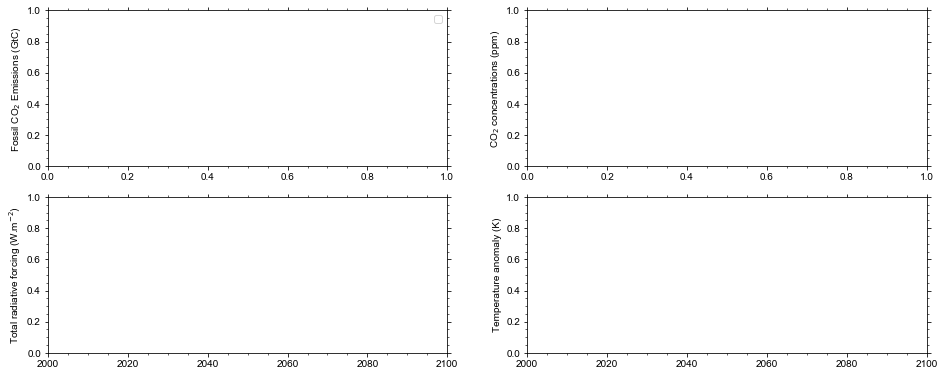

In [19]:
    
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 10
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True

#fig, ax = pl.subplots(1,3)
fig = pl.figure(figsize=(40/2.54, 16/2.54))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


C22, F22, T22 = fair_mod.forward.fair_scm(emissions=emissions_g2_2,
                                             F_volcanic=Fvolcanic_month,F_solar=Fsolar_month,
                                             natural=naturale_month)
Cbase, Fbase, Tbase = fair_mod.forward.fair_scm(emissions=emissions_base,
                                             F_volcanic=Fvolcanic_month,F_solar=Fsolar_month,
                                             natural=naturale_month)
C13, F13, T22 = fair_mod.forward.fair_scm(emissions=emissions_g1_3,
                                             F_volcanic=Fvolcanic_month,F_solar=Fsolar_month,
                                             natural=naturale_month)
C3, F3, T3 = fair_mod.forward.fair_scm(emissions=emissions_g3,
                                             F_volcanic=Fvolcanic_month,F_solar=Fsolar_month,
                                             natural=naturale_month)
C4, F4, T4 = fair_mod.forward.fair_scm(emissions=emissions_g4,
                                             F_volcanic=Fvolcanic_month,F_solar=Fsolar_month,
                                             natural=naturale_month)

#ax1.plot(emissions_base[:,0], emissions_base[:,1], color='brown', label='Covid1')
#ax2.plot(emissions_covid1[:,0], Cc1[:, 0], color='brown')
#ax3.plot(emissions_covid1[:,0], np.sum(Fc1, axis=1), color='brown')
#ax4.plot(emissions_covid1[:,0], Tc1, color='brown')

time=emissions_base[:,0]

Cndc, Fndc, Tndc = fair.forward.fair_scm(emissions=emissions_ndc)
#ax1.plot(rcp6.Emissions.year, rcp6.Emissions.co2_fossil, color='red', label='RCP6')
#ax2.plot(rcp6.Emissions.year, C60[:, 0], color='red')
#ax3.plot(rcp6.Emissions.year, np.sum(F60, axis=1), color='red')
#ax4.plot(rcp6.Emissions.year, T60, color='red')

#C85, F85, T85 = fair.forward.fair_scm(emissions=rcp85.Emissions.emissions)
#ax1.plot(rcp85.Emissions.year, rcp85.Emissions.co2_fossil, color='black', label='RCP8.5')
#ax2.plot(rcp85.Emissions.year, C85[:, 0], color='black')
#ax3.plot(rcp85.Emissions.year, np.sum(F85, axis=1), color='black')
#ax4.plot(rcp85.Emissions.year, T85, color='black')
#ax1.set_xlim(2000,2100)
#ax2.set_xlim(2000,2100)
ax3.set_xlim(2000,2100)
ax4.set_xlim(2000,2100)
ax1.set_ylabel('Fossil CO$_2$ Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Total radiative forcing (W.m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)');

Text(0.5, 1.0, 'Major forcing components (W.m$^{-2}$)')

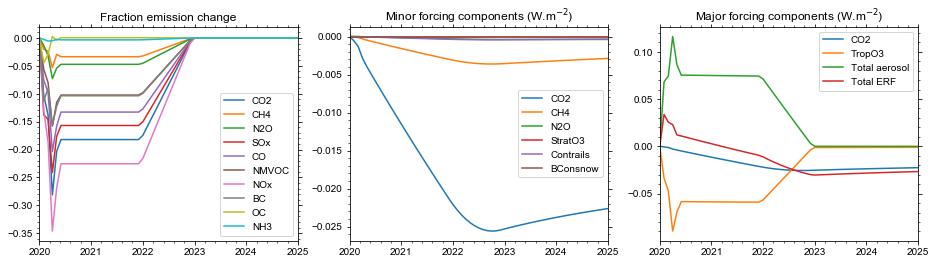

In [20]:
#plot emissions and forcing
fig, ax = pl.subplots(1,3, figsize=(40/2.54, 10/2.54))

ax[0].plot(time,(emissions_g3[:,1:2].sum(axis=1)-emissions_base[:,1:2].sum(axis=1))/emissions_base[:,1:2].sum(axis=1),label='CO2')
ax[0].plot(time,(emissions_g3[:,3]-emissions_base[:,3])/emissions_base[:,3],label='CH4')
ax[0].plot(time,(emissions_g3[:,4]-emissions_base[:,4])/emissions_base[:,4],label='N2O')
ax[0].plot(time,(emissions_g3[:,5]-emissions_base[:,5])/emissions_base[:,5],label='SOx')
ax[0].plot(time,(emissions_g3[:,6]-emissions_base[:,6])/emissions_base[:,6],label='CO')
ax[0].plot(time,(emissions_g3[:,7]-emissions_base[:,7])/emissions_base[:,7],label='NMVOC')
ax[0].plot(time,(emissions_g3[:,8]-emissions_base[:,8])/emissions_base[:,8],label='NOx')
ax[0].plot(time,(emissions_g3[:,9]-emissions_base[:,9])/emissions_base[:,9],label='BC')
ax[0].plot(time,(emissions_g3[:,10]-emissions_base[:,10])/emissions_base[:,10],label='OC')
ax[0].plot(time,(emissions_g3[:,11]-emissions_base[:,11])/emissions_base[:,11],label='NH3')
ax[0].legend(fontsize=10)
ax[0].set_xlim(2020,2025)
ax[0].set_title('Fraction emission change')
#forcing

ax[1].plot(time,(F3[:,0]-Fbase[:,0]),label='CO2')
ax[1].plot(time,(F3[:,1]-Fbase[:,1]),label='CH4')
ax[1].plot(time,(F3[:,2]-Fbase[:,2]),label='N2O')
#ax[1].plot(time,(F3[:,4]-Fbase[:,4]),label='TropO3')
ax[1].plot(time,(F3[:,5]-Fbase[:,5]),label='StratO3')
ax[1].plot(time,(F3[:,6]-Fbase[:,6]),label='Contrails')
ax[1].plot(time,(F3[:,7]-Fbase[:,7]),label='BConsnow')
#ax[1].plot(time,(F3[:,8]-Fbase[:,8]),label='Total aerosol')

ax[1].legend(fontsize=10)
ax[1].set_xlim(2020,2025)
ax[1].set_title('Minor forcing components (W.m$^{-2}$)')


ax[2].plot(time,(F3[:,0]-Fbase[:,0]),label='CO2')

ax[2].plot(time,(F3[:,4]-Fbase[:,4]),label='TropO3')
ax[2].plot(time,(F3[:,8]-Fbase[:,8]),label='Total aerosol')
ax[2].plot(time,(F3[:,:].sum(axis=1)-Fbase[:,:].sum(axis=1)),label='Total ERF')
ax[2].legend(fontsize=10)
ax[2].set_xlim(2020,2025)
#ax[2].set_ylim(-0.006,0)
ax[2].set_title('Major forcing components (W.m$^{-2}$)')

array([0.03839071, 0.03813383, 0.03813541, ..., 0.38135742, 0.38112506,
       0.38089261])

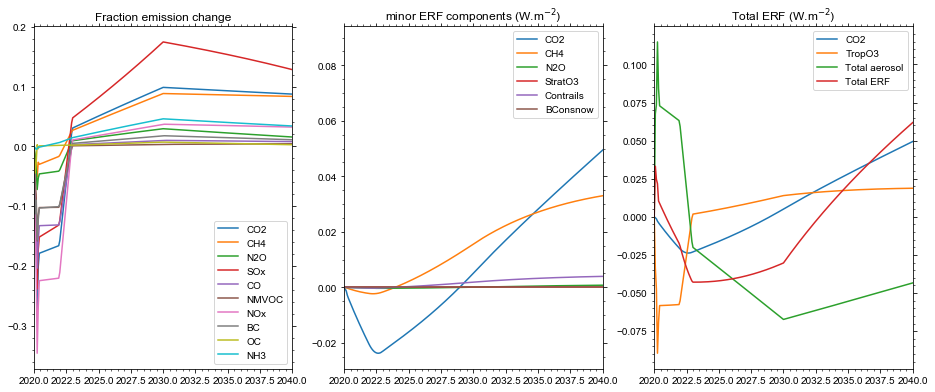

In [21]:
#plot emissions and forcing
fig, ax = pl.subplots(1,3, figsize=(40/2.54, 16/2.54))

ax[0].plot(time,(emissions_g2_2[:,1:2].sum(axis=1)-emissions_base[:,1:2].sum(axis=1))/emissions_base[:,1:2].sum(axis=1),label='CO2')
ax[0].plot(time,(emissions_g2_2[:,3]-emissions_base[:,3])/emissions_base[:,3],label='CH4')
ax[0].plot(time,(emissions_g2_2[:,4]-emissions_base[:,4])/emissions_base[:,4],label='N2O')
ax[0].plot(time,(emissions_g2_2[:,5]-emissions_base[:,5])/emissions_base[:,5],label='SOx')
ax[0].plot(time,(emissions_g2_2[:,6]-emissions_base[:,6])/emissions_base[:,6],label='CO')
ax[0].plot(time,(emissions_g2_2[:,7]-emissions_base[:,7])/emissions_base[:,7],label='NMVOC')
ax[0].plot(time,(emissions_g2_2[:,8]-emissions_base[:,8])/emissions_base[:,8],label='NOx')
ax[0].plot(time,(emissions_g2_2[:,9]-emissions_base[:,9])/emissions_base[:,9],label='BC')
ax[0].plot(time,(emissions_g2_2[:,10]-emissions_base[:,10])/emissions_base[:,10],label='OC')
ax[0].plot(time,(emissions_g2_2[:,11]-emissions_base[:,11])/emissions_base[:,11],label='NH3')
ax[0].legend(fontsize=10)
ax[0].set_xlim(2020,2040)
ax[0].set_title('Fraction emission change')
#forcing

ax[1].plot(time,(F22[:,0]-Fbase[:,0]),label='CO2')
ax[1].plot(time,(F22[:,1]-Fbase[:,1]),label='CH4')
ax[1].plot(time,(F22[:,2]-Fbase[:,2]),label='N2O')
#ax[1].plot(time,(F3[:,4]-Fbase[:,4]),label='TropO3')
ax[1].plot(time,(F22[:,5]-Fbase[:,5]),label='StratO3')
ax[1].plot(time,(F22[:,6]-Fbase[:,6]),label='Contrails')
ax[1].plot(time,(F22[:,7]-Fbase[:,7]),label='BConsnow')
#ax[1].plot(time,(F3[:,8]-Fbase[:,8]),label='Total aerosol')

ax[1].legend(fontsize=10)
ax[1].set_xlim(2020,2040)
ax[1].set_title('minor ERF components (W.m$^{-2}$)')


ax[2].plot(time,(F22[:,0]-Fbase[:,0]),label='CO2')

ax[2].plot(time,(F22[:,4]-Fbase[:,4]),label='TropO3')
ax[2].plot(time,(F22[:,8]-Fbase[:,8]),label='Total aerosol')
ax[2].plot(time,(F22[:,:].sum(axis=1)-Fbase[:,:].sum(axis=1)),label='Total ERF')
ax[2].legend(fontsize=10)
ax[2].set_xlim(2020,2040)
ax[2].set_title('Total ERF (W.m$^{-2}$)')

F22[:,4]

Text(0.5, 1.0, 'Total ERF (W.m$^{-2}$)')

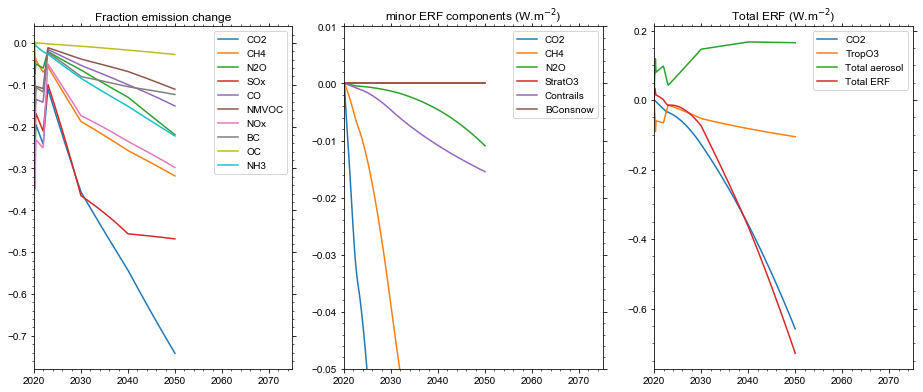

In [22]:
#plot emissions and forcing
fig, ax = pl.subplots(1,3, figsize=(40/2.54, 16/2.54))

ax[0].plot(time,(emissions_g1_3[:,1:2].sum(axis=1)-emissions_base[:,1:2].sum(axis=1))/emissions_base[:,1:2].sum(axis=1),label='CO2')
ax[0].plot(time,(emissions_g1_3[:,3]-emissions_base[:,3])/emissions_base[:,3],label='CH4')
ax[0].plot(time,(emissions_g1_3[:,4]-emissions_base[:,4])/emissions_base[:,4],label='N2O')
ax[0].plot(time,(emissions_g1_3[:,5]-emissions_base[:,5])/emissions_base[:,5],label='SOx')
ax[0].plot(time,(emissions_g1_3[:,6]-emissions_base[:,6])/emissions_base[:,6],label='CO')
ax[0].plot(time,(emissions_g1_3[:,7]-emissions_base[:,7])/emissions_base[:,7],label='NMVOC')
ax[0].plot(time,(emissions_g1_3[:,8]-emissions_base[:,8])/emissions_base[:,8],label='NOx')
ax[0].plot(time,(emissions_g1_3[:,9]-emissions_base[:,9])/emissions_base[:,9],label='BC')
ax[0].plot(time,(emissions_g1_3[:,10]-emissions_base[:,10])/emissions_base[:,10],label='OC')
ax[0].plot(time,(emissions_g1_3[:,11]-emissions_base[:,11])/emissions_base[:,11],label='NH3')
ax[0].legend(fontsize=10)
ax[0].set_xlim(2020,2075)
ax[0].set_title('Fraction emission change')
#forcing

ax[1].plot(time,(F13[:,0]-Fbase[:,0]),label='CO2')
ax[1].plot(time,(F13[:,1]-Fbase[:,1]),label='CH4')
ax[1].plot(time,(F13[:,2]-Fbase[:,2]),label='N2O')
#ax[1].plot(time,(F3[:,4]-Fbase[:,4]),label='TropO3')
ax[1].plot(time,(F13[:,5]-Fbase[:,5]),label='StratO3')
ax[1].plot(time,(F13[:,6]-Fbase[:,6]),label='Contrails')
ax[1].plot(time,(F13[:,7]-Fbase[:,7]),label='BConsnow')
#ax[1].plot(time,(F3[:,8]-Fbase[:,8]),label='Total aerosol')

ax[1].legend(fontsize=10)
ax[1].set_xlim(2020,2075)
ax[1].set_ylim(-0.05,0.01)
ax[1].set_title('minor ERF components (W.m$^{-2}$)')


ax[2].plot(time,(F13[:,0]-Fbase[:,0]),label='CO2')

ax[2].plot(time,(F13[:,4]-Fbase[:,4]),label='TropO3')
ax[2].plot(time,(F13[:,8]-Fbase[:,8]),label='Total aerosol')
ax[2].plot(time,(F13[:,:].sum(axis=1)-Fbase[:,:].sum(axis=1)),label='Total ERF')
ax[2].legend(fontsize=10)
ax[2].set_xlim(2020,2075)
ax[2].set_title('Total ERF (W.m$^{-2}$)')

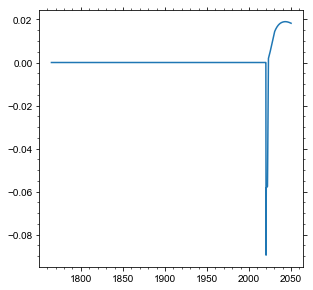

In [23]:
pl.plot(time,F22[:,4]-Fbase[:,4])

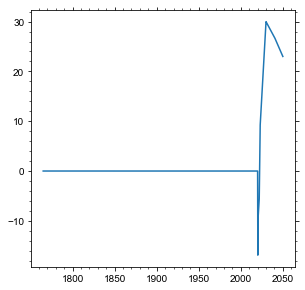

In [24]:
pl.plot(time,emissions_g2_2[:,3]-emissions_base[:,3])

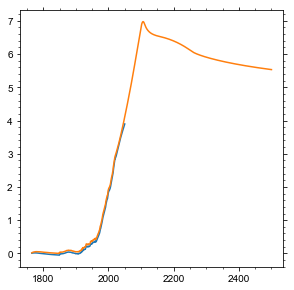

In [25]:
inp=Fndc.copy()
names=['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric',
       'h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions','volcanic','solar']
base=pd.DataFrame(columns=names,data=inp)
base['year']=emissions_ndc[:,0]
base['total_natural']=base[['solar','volcanic']].sum(axis=1)
base['total_anthropogenic'] = base[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions']].sum(axis=1)
base['total'] = base['total_anthropogenic'] 
NDC_forcing=base

inp=Fbase.copy()
names=['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric',
       'h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions','volcanic','solar']
base=pd.DataFrame(columns=names,data=inp)
base['year']=emissions_base[:,0]
base['total_natural']=base[['solar','volcanic']].sum(axis=1)
base['total_anthropogenic'] = base[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions']].sum(axis=1)
base['total'] = base['total_anthropogenic'] 
Covbase_forcing=base

inp=F22.copy()
names=['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric',
       'h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions','volcanic','solar']
base=pd.DataFrame(columns=names,data=inp)
base['year']=emissions_base[:,0]
base['total_natural']=base[['solar','volcanic']].sum(axis=1)
base['total_anthropogenic'] = base[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions']].sum(axis=1)
base['total'] = base['total_anthropogenic'] 
Cov22_forcing=base

inp=F13.copy()
names=['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric',
       'h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions','volcanic','solar']
base=pd.DataFrame(columns=names,data=inp)
base['year']=emissions_base[:,0]
base['total_natural']=base[['solar','volcanic']].sum(axis=1)
base['total_anthropogenic'] = base[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions']].sum(axis=1)
base['total'] = base['total_anthropogenic'] 
Cov13_forcing=base

inp=F3.copy()
names=['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric',
       'h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions','volcanic','solar']
base=pd.DataFrame(columns=names,data=inp)
base['year']=emissions_base[:,0]
base['total_natural']=base[['solar','volcanic']].sum(axis=1)
base['total_anthropogenic'] = base[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions']].sum(axis=1)
base['total'] = base['total_anthropogenic'] 
Cov3_forcing=base

inp=F4.copy()
names=['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric',
       'h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions','volcanic','solar']
base=pd.DataFrame(columns=names,data=inp)
base['year']=emissions_base[:,0]
base['total_natural']=base[['solar','volcanic']].sum(axis=1)
base['total_anthropogenic'] = base[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-cloud_interactions']].sum(axis=1)
base['total'] = base['total_anthropogenic'] 
Cov4_forcing=base



pl.plot(emissions_base[:,0],Cov3_forcing['total'])
pl.plot(emissions_ndc[:,0],NDC_forcing['total'])

In [26]:
#runs CMIP6 model emulator with AR5 forcing for all models avialable 
#dela=['hflux', 'lam_eff', 'ohc', 'params', 'qtot','tlev']
#for m in mod_nam:
#    print (m),print(mo[mod_nam.index(m)])
#    moi=mo[mod_nam.index(m)]
samples=100
import random
random.seed(a=47)
temp = np.zeros((335, samples))
forc=temp.copy()
for i in range(samples):
    in_forcing = NDC_forcing.copy()
    in_forcing.drop(in_forcing.index[335:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing = in_forcing* scale_df.iloc[i]
#    in_forcing['aerosol-radiation_interactions'] = ERFari[:350,i]
#    in_forcing['aerosol-cloud_interactions'] = ERFaci[:350,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
#    in_forcing['total'] = in_forcing['co2']
#    print (i, in_forcing.shape)
    m=mod_nam[random.randint(0,len(mo)-1,)] #randomly choose a CMIP6 model
    scm_test = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1765,
        tend=2100,
        outtime=np.arange(1765.5,2100),
        dt=0.2,
        q2x=params['q4x']['model_data']['EBM-epsilon'][m]/2,
        lamg=-params['lamg']['model_data']['EBM-epsilon'][m],
        t2x=None,#3.00,
        eff=params['eff']['model_data']['EBM-epsilon'][m],
        cmix=params['cmix']['model_data']['EBM-epsilon'][m],
        cdeep=params['cdeep']['model_data']['EBM-epsilon'][m],
        gamma_2l=params['gamma_2l']['model_data']['EBM-epsilon'][m],
    )
    
    out_test = scm_test.run()
    temp[:,i] = out_test.tg - np.mean(out_test.tg[100-14:150-14])
    forc[:,i] = in_forcing['total']
    
#    print (in_forcing['total'].iloc[349])
#    print(i,m,in_forcing.index[349],in_forcing['total'].iloc[349],temp[349,i])
#    print (i,in_forcing['total'][349],m,temp[349,i])
#    print(dir(out_test))
#    for i in dela:
#        if hasattr(out_test,i):
#            delattr(out_test,i)
#    setattr(CMIP6_SSP245, moi, out_test)
NDCt=temp.copy()
NDCf=forc.copy()

In [27]:
random.seed(a=47)
temp = np.zeros((3421, samples))
forc = temp.copy()
for i in range(samples):
    in_forcing = Covbase_forcing.copy()
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing = in_forcing* scale_df.iloc[i]
#    print ('forcing ',in_forcing['aerosol-radiation_interactions'].shape)
#    in_forcing['aerosol-radiation_interactions'] = ERFari[:350,i]
#    in_forcing['aerosol-cloud_interactions'] = ERFaci[:350,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
#    in_forcing['total'] = in_forcing['co2']
#    print (i, in_forcing.shape)
    m=mod_nam[random.randint(0,len(mo)-1,)] #randomly choose a CMIP6 model
    scm_test = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1765,
        tend=2050,
        outtime=emissions_base[:,0],
        dt=1.0/24,
        q2x=params['q4x']['model_data']['EBM-epsilon'][m]/2,
        lamg=-params['lamg']['model_data']['EBM-epsilon'][m],
        t2x=None,#3.00,
        eff=params['eff']['model_data']['EBM-epsilon'][m],
        cmix=params['cmix']['model_data']['EBM-epsilon'][m],
        cdeep=params['cdeep']['model_data']['EBM-epsilon'][m],
        gamma_2l=params['gamma_2l']['model_data']['EBM-epsilon'][m],
    )
    
    out_test = scm_test.run()
    temp[:,i] = out_test.tg - np.mean(out_test.tg[100-14:150-14])
    forc[:,i] = in_forcing['total']
Covbaset=temp.copy()
Covbasef=forc.copy()

In [28]:
random.seed(a=47)
temp = np.zeros((3421, samples))
forc = temp.copy()
for i in range(samples):
    in_forcing = Cov22_forcing.copy()
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing = in_forcing* scale_df.iloc[i]
#    print ('forcing ',in_forcing['aerosol-radiation_interactions'].shape)
#    in_forcing['aerosol-radiation_interactions'] = ERFari[:350,i]
#    in_forcing['aerosol-cloud_interactions'] = ERFaci[:350,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
#    in_forcing['total'] = in_forcing['co2']
#    print (i, in_forcing.shape)
    m=mod_nam[random.randint(0,len(mo)-1,)] #randomly choose a CMIP6 model
    scm_test = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1765,
        tend=2050,
        outtime=emissions_base[:,0],
        dt=1.0/24,
        q2x=params['q4x']['model_data']['EBM-epsilon'][m]/2,
        lamg=-params['lamg']['model_data']['EBM-epsilon'][m],
        t2x=None,#3.00,
        eff=params['eff']['model_data']['EBM-epsilon'][m],
        cmix=params['cmix']['model_data']['EBM-epsilon'][m],
        cdeep=params['cdeep']['model_data']['EBM-epsilon'][m],
        gamma_2l=params['gamma_2l']['model_data']['EBM-epsilon'][m],
    )
    
    out_test = scm_test.run()
    temp[:,i] = out_test.tg - np.mean(out_test.tg[100-14:150-14])
    forc[:,i] = in_forcing['total']
Cov22t=temp.copy()
Cov22f=forc.copy()

In [29]:
random.seed(a=47)
temp = np.zeros((3421, samples))
forc = temp.copy()
for i in range(samples):
    in_forcing = Cov13_forcing.copy()
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing = in_forcing* scale_df.iloc[i]
#    print ('forcing ',in_forcing['aerosol-radiation_interactions'].shape)
#    in_forcing['aerosol-radiation_interactions'] = ERFari[:350,i]
#    in_forcing['aerosol-cloud_interactions'] = ERFaci[:350,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
#    in_forcing['total'] = in_forcing['co2']
#    print (i, in_forcing.shape)
    m=mod_nam[random.randint(0,len(mo)-1,)] #randomly choose a CMIP6 model
    scm_test = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1765,
        tend=2050,
        outtime=emissions_base[:,0],
        dt=1.0/24,
        q2x=params['q4x']['model_data']['EBM-epsilon'][m]/2,
        lamg=-params['lamg']['model_data']['EBM-epsilon'][m],
        t2x=None,#3.00,
        eff=params['eff']['model_data']['EBM-epsilon'][m],
        cmix=params['cmix']['model_data']['EBM-epsilon'][m],
        cdeep=params['cdeep']['model_data']['EBM-epsilon'][m],
        gamma_2l=params['gamma_2l']['model_data']['EBM-epsilon'][m],
    )
    
    out_test = scm_test.run()
    temp[:,i] = out_test.tg - np.mean(out_test.tg[100-14:150-14])
    forc[:,i] = in_forcing['total']
Cov13t=temp.copy()
Cov13f=forc.copy()

In [30]:
random.seed(a=47)
temp = np.zeros((3421, samples))
forc = temp.copy()
for i in range(samples):
    in_forcing = Cov3_forcing.copy()
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing = in_forcing* scale_df.iloc[i]
#    print ('forcing ',in_forcing['aerosol-radiation_interactions'].shape)
#    in_forcing['aerosol-radiation_interactions'] = ERFari[:350,i]
#    in_forcing['aerosol-cloud_interactions'] = ERFaci[:350,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
#    in_forcing['total'] = in_forcing['co2']
#    print (i, in_forcing.shape)
    m=mod_nam[random.randint(0,len(mo)-1,)] #randomly choose a CMIP6 model
    scm_test = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1765,
        tend=2050,
        outtime=emissions_base[:,0],
        dt=1.0/24,
        q2x=params['q4x']['model_data']['EBM-epsilon'][m]/2,
        lamg=-params['lamg']['model_data']['EBM-epsilon'][m],
        t2x=None,#3.00,
        eff=params['eff']['model_data']['EBM-epsilon'][m],
        cmix=params['cmix']['model_data']['EBM-epsilon'][m],
        cdeep=params['cdeep']['model_data']['EBM-epsilon'][m],
        gamma_2l=params['gamma_2l']['model_data']['EBM-epsilon'][m],
    )
    
    out_test = scm_test.run()
    temp[:,i] = out_test.tg - np.mean(out_test.tg[100-14:150-14])
    forc[:,i] = in_forcing['total']
Cov3t=temp.copy()
Cov3f=forc.copy()

In [31]:
random.seed(a=47)
temp = np.zeros((3421, samples))
forc = temp.copy()
for i in range(samples):
    in_forcing = Cov4_forcing.copy()
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing = in_forcing* scale_df.iloc[i]
#    print ('forcing ',in_forcing['aerosol-radiation_interactions'].shape)
#    in_forcing['aerosol-radiation_interactions'] = ERFari[:350,i]
#    in_forcing['aerosol-cloud_interactions'] = ERFaci[:350,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
#    in_forcing['total'] = in_forcing['co2']
#    print (i, in_forcing.shape)
    m=mod_nam[random.randint(0,len(mo)-1,)] #randomly choose a CMIP6 model
    scm_test = scmpy.scmpy2l.ScmDef(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1765,
        tend=2050,
        outtime=emissions_base[:,0],
        dt=1.0/24,
        q2x=params['q4x']['model_data']['EBM-epsilon'][m]/2,
        lamg=-params['lamg']['model_data']['EBM-epsilon'][m],
        t2x=None,#3.00,
        eff=params['eff']['model_data']['EBM-epsilon'][m],
        cmix=params['cmix']['model_data']['EBM-epsilon'][m],
        cdeep=params['cdeep']['model_data']['EBM-epsilon'][m],
        gamma_2l=params['gamma_2l']['model_data']['EBM-epsilon'][m],
    )
    
    out_test = scm_test.run()
    temp[:,i] = out_test.tg - np.mean(out_test.tg[100-14:150-14])
    forc[:,i] = in_forcing['total']
Cov4t=temp.copy()
Cov4f=forc.copy()

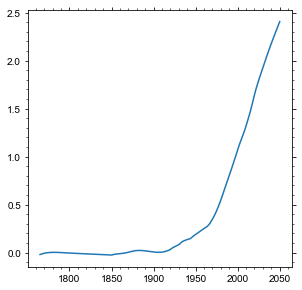

In [32]:
pl.plot(time,Covbaset[:,34])

In [33]:
print (time[100],time[100+len(Tobs)-1])
print (years[0], years[len(Tobs)-1])
#time


1773.3333333333333 1787.4166666666667
1850.5 2019.5


In [34]:
len(time)

3421

65 77 52
65 77 52
65 77 67
65 77 52
43 76 87


Text(0, 0.5, 'Temperature change relative to 1850-1900, K')

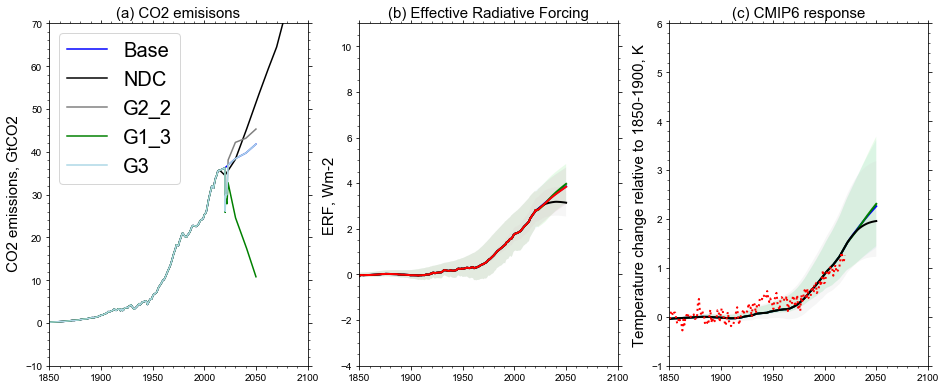

In [35]:
fig, ax = pl.subplots(1,3, figsize=(40/2.54, 16/2.54))

#pl.rcParams.update({'font.size': 15})

def runm(fl):
    return fl.rolling(10, min_periods=1).mean()

#emission plot
x=in_forcing.index
x1=1765+np.arange(335)
ax[0].plot(x,emissions_base[:,1]*3.67,color='blue',label='Base')
ax[0].plot(x1,emissions_ndc[:335,1]*3.67,color='black',label='NDC')
ax[0].plot(x,emissions_g2_2[:,1]*3.67,color='grey',label='G2_2')
ax[0].plot(x,emissions_g1_3[:,1]*3.67,color='green',label='G1_3')
ax[0].plot(x,emissions_g3[:,1]*3.67,color='lightblue',label='G3')
ax[0].legend(fontsize=20)
ax[0].set_title('(a) CO2 emisisons',fontsize=15)
ax[0].set_xlim(1850,2100)
ax[0].set_ylim(-10,70)
ax[0].set_ylabel(' CO2 emissions, GtCO2',fontsize=15)
#base forcing
endF=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=in_forcing.index
    y=Covbasef[:,i]
    endF.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

f2100=pd.DataFrame(columns=['Sample','F@2100'])
f2100['Sample'] =np.arange(samples)
f2100['F@2100'] =endF
f2100sort=f2100.sort_values('F@2100',ignore_index=True)
print (f2100sort['Sample'][1],f2100sort['Sample'][13],f2100sort['Sample'][24])
x=time
y1=Covbasef[:,f2100sort['Sample'][int(round(samples*0.05))]]
y2=Covbasef[:,f2100sort['Sample'][int(round(samples*0.95))]]
ax[1].fill_between(x, y1, y2,facecolor='lightblue',alpha=0.2)
y=model_mean
y460=y.copy()
ax[1].plot(x, y, color='blue',linewidth=2,label='Covbase')

#Cov22 forcing
endF=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=time
    y=Cov22f[:,i]
    endF.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

f2100=pd.DataFrame(columns=['Sample','F@2100'])
f2100['Sample'] =np.arange(samples)
f2100['F@2100'] =endF
f2100sort=f2100.sort_values('F@2100',ignore_index=True)
print (f2100sort['Sample'][1],f2100sort['Sample'][13],f2100sort['Sample'][24])
x=time
y1=Cov22f[:,f2100sort['Sample'][int(round(samples*0.05))]]
y2=Cov22f[:,f2100sort['Sample'][int(round(samples*0.95))]]
ax[1].fill_between(x, y1, y2,facecolor='lightgreen',alpha=0.2)
y=model_mean
ax[1].plot(x, y, color='green',linewidth=2,label='Cov22')


#Cov13 forcing
endF=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=in_forcing.index
    y=Cov13f[:,i]
    endF.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

f2100=pd.DataFrame(columns=['Sample','F@2100'])
f2100['Sample'] =np.arange(samples)
f2100['F@2100'] =endF
f2100sort=f2100.sort_values('F@2100',ignore_index=True)
print (f2100sort['Sample'][1],f2100sort['Sample'][13],f2100sort['Sample'][24])
x=time
y1=Cov13f[:,f2100sort['Sample'][int(round(samples*0.05))]]
y2=Cov13f[:,f2100sort['Sample'][int(round(samples*0.95))]]
ax[1].fill_between(x, y1, y2,facecolor='lightgray',alpha=0.2)
y=model_mean
ax[1].plot(x, y, color='black',linewidth=2,label='Cov13')

#Cov3 forcing
endF=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=in_forcing.index
    y=Cov3f[:,i]
    endF.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

f2100=pd.DataFrame(columns=['Sample','F@2100'])
f2100['Sample'] =np.arange(samples)
f2100['F@2100'] =endF
f2100sort=f2100.sort_values('F@2100',ignore_index=True)
print (f2100sort['Sample'][1],f2100sort['Sample'][13],f2100sort['Sample'][24])
x=time
y1=Cov3f[:,f2100sort['Sample'][int(round(samples*0.05))]]
y2=Cov3f[:,f2100sort['Sample'][int(round(samples*0.95))]]
ax[1].fill_between(x, y1, y2,facecolor='pink',alpha=0.2)
y=model_mean
ax[1].plot(x, y, color='red',linewidth=2,label='C1')
yC1=y.copy()
#for ic in range(30): #checking pinatubo
#    print (x[ic+220],y[ic+220])
#ax[0].plot(out_Lund_3K.time, out_Lund_3K.tg-np.mean(out_Lund_3K.tg[100:151]), label='Lund et al., 2019', color='pink', alpha=0.7)
#ax[1].legend(fontsize=20)
ax[1].set_title('(b) Effective Radiative Forcing',fontsize=15)
ax[1].set_xlim(1850,2100)
ax[1].set_ylim(-4,11)
ax[1].set_ylabel('ERF, Wm-2',fontsize=15)


#Covbase
endT=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=in_forcing.index
    y=Covbaset[:,i]
    endT.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

t2100=pd.DataFrame(columns=['Sample','T@2100'])
t2100['Sample'] =np.arange(samples)
t2100['T@2100'] =endT
t2100sort=t2100.sort_values('T@2100',ignore_index=True)
#print (t2100sort['Sample'][1],t2100sort['Sample'][13],t2100sort['Sample'][24])
x=time
y1=Covbaset[:,t2100sort['Sample'][int(round(samples*0.05))]]
y2=Covbaset[:,t2100sort['Sample'][int(round(samples*0.95))]]
ax[2].fill_between(x, y1, y2,facecolor='lightblue',alpha=0.2)
y=model_mean
ax[2].plot(x, y, color='blue',linewidth=2,label='Base')

#Cov22
endT=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=time
    y=Cov22t[:,i]
    endT.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

t2100=pd.DataFrame(columns=['Sample','T@2100'])
t2100['Sample'] =np.arange(samples)
t2100['T@2100'] =endT
t2100sort=t2100.sort_values('T@2100',ignore_index=True)
#print (t2100sort['Sample'][1],t2100sort['Sample'][samples*0.05],t2100sort['Sample'][samples*0.95])
x=time
y1=Cov22t[:,t2100sort['Sample'][int(round(samples*0.05))]]
y2=Cov22t[:,t2100sort['Sample'][int(round(samples*0.95))]]
#ax[0,1].fill_between(x, y1-y1[270]+1.1, y2-y2[270]+1.1,facecolor='lightgreen',alpha=0.2)
ax[2].fill_between(x, y1, y2,facecolor='lightgreen',alpha=0.2)
y=model_mean
ax[2].plot(x, y, color='green',linewidth=2,label='Cov22')

#Cov13
endT=[]
mean = np.zeros(len(time))
for i in range(samples):
#    print(i)
    #    myObj = str_to_class(i)
    x=time
    y=Cov13t[:,i]
    endT.append(y[-1])
    mean[:]=mean[:]+y
model_mean=mean[:]/samples

t2100=pd.DataFrame(columns=['Sample','T@2100'])
t2100['Sample'] =np.arange(samples)
t2100['T@2100'] =endT
t2100sort=t2100.sort_values('T@2100',ignore_index=True)
print (t2100sort['Sample'][1],t2100sort['Sample'][13],t2100sort['Sample'][24])

y1=Cov13t[:,t2100sort['Sample'][int(round(samples*0.05))]]
y2=Cov13t[:,t2100sort['Sample'][int(round(samples*0.95))]]
ax[2].fill_between(x, y1, y2,facecolor='lightgray',alpha=0.2)
y=model_mean
ax[2].plot(x, y, color='black',linewidth=2,label='NDC')

#add observations
ax[2].plot(years,Tobs,linewidth=2,linestyle=':',color='red')

ax[2].set_title('(c) CMIP6 response',fontsize=15)
ax[2].set_xlim(1850,2100)
ax[2].set_ylim(-1,6.0)
ax[2].set_ylabel('Temperature change relative to 1850-1900, K',fontsize=15)



In [36]:
#fig, ax = pl.subplots(1,1, figsize=(16/2.54, 16/2.54))
#for i in range(len(SSP460t_s[:,imax_S460])):
#ax.plot(np.cumsum(emissions_covid1[:335,1]*3.67),C1t[:,1],color='red')
#ax.plot(np.cumsum(emissions_ssp460[:335,1]*3.67),SSP460t[:,1],color='blue')
#ax.plot(np.cumsum(emissions_ssp126[:335,1]*3.67),SSP126t[:,1],color='green')
#ax.plot(np.cumsum(emissions_ndc[:335,1]*3.67),NDCt[:,1],color='black')

In [37]:
#SSP126

#mean = np.zeros(len(getattr(CMIP6_SSP126,t2100sort['Models'][2]).time))
#for i in mo:
#    print(i)
    #    myObj = str_to_class(i)
#    x=getattr(CMIP6_SSP126,i).time
#    y=getattr(CMIP6_SSP126,i).tg


In [38]:



Covbaset_s = Covbaset[:,t2100sort['Sample']]
Covbasef_s = Covbasef[:,t2100sort['Sample']]

Cov22t_s = Cov22t[:,t2100sort['Sample']]
Cov22f_s = Cov22f[:,t2100sort['Sample']]

Cov13t_s = Cov13t[:,t2100sort['Sample']]
Cov13f_s = Cov13f[:,t2100sort['Sample']]

Cov3t_s = Cov3t[:,t2100sort['Sample']]
Cov3f_s = Cov3f[:,t2100sort['Sample']]

Cov4t_s = Cov4t[:,t2100sort['Sample']]
Cov4f_s = Cov4f[:,t2100sort['Sample']]

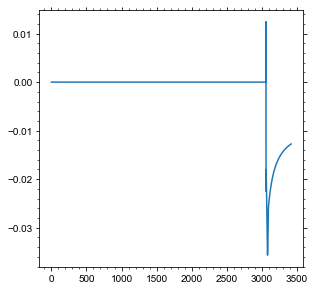

In [39]:
pl.plot(Cov3f_s[:,15]-Covbasef_s[:,15])

In [40]:
td=pd.DataFrame(columns=['Sample','T'])
td['Sample'] =np.arange(len(NDCt[0,:]))
td['T'] =NDCt[-1,:]
tdsort=td.sort_values('T',ignore_index=True)
NDCt_s=NDCt[:,tdsort['Sample']]

2 73


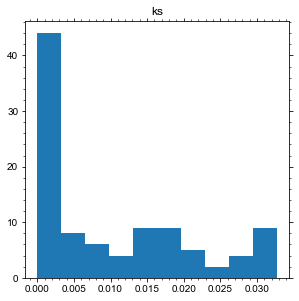

In [41]:
#now constrain by applying knutti_score weights
ks= knutti_score(Tobs,NDCt_s[100-14:100-14+len(Tobs),:])
#print(ks)
pl.hist(ks);
pl.title('ks');
cks = np.cumsum(ks)
#print (ks)
i5 = np.where(cks >=0.05)[0][0]
i95 = np.where(cks >=0.95)[0][0]
imax= np.where(ks ==np.amax(ks))[0][0]

print (i5,i95)

In [42]:
ks.shape

(100,)

In [43]:
C22.shape

(3421, 31)

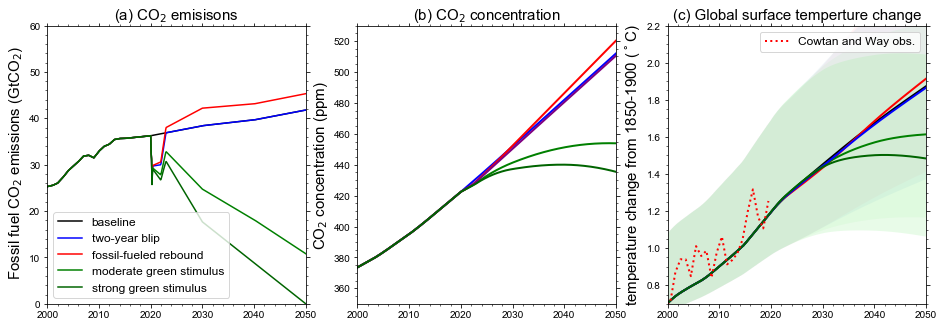

In [47]:
fig, ax = pl.subplots(1,3, figsize=(40/2.54, 13/2.54))

x=time

#emission plot
x=in_forcing.index
x1=1765+np.arange(335)
ax[0].plot(x,emissions_base[:,1]*3.67,color='black',label='baseline')
#ax[0].plot(x1,emissions_ndc[:335,1]*3.67,color='black',label='NDC')
ax[0].plot(x,emissions_g3[:,1]*3.67,color='blue',label='two-year blip')
ax[0].plot(x,emissions_g2_2[:,1]*3.67,color='red',label='fossil-fueled rebound')
ax[0].plot(x,emissions_g1_3[:,1]*3.67,color='green',label='moderate green stimulus')
ax[0].plot(x,emissions_g4[:,1]*3.67,color='darkgreen',label='strong green stimulus')

ax[0].legend(fontsize=12)
ax[0].set_title('(a) CO$_2$ emisisons',fontsize=15)
ax[0].set_xlim(2000,2050)
ax[0].set_ylim(0,60)
ax[0].set_ylabel(' Fossil fuel CO$_2$ emissions (GtCO$_2$)',fontsize=15)
#x=np.arange(350)+1750.0
#Covbase forcing
#ax[1].fill_between(x, Covbasef_s[:,i5], Covbasef_s[:,i95],facecolor='lightblue',alpha=0.2)
#ax[1].plot(x,(Covbasef_s[:,:]*ks).sum(axis=1), color='blue',linewidth=2,label='Covbase')
#ax[1].fill_between(x, Cov22f_s[:,i5], Cov22f_s[:,i95],facecolor='pink',alpha=0.2)
#ax[1].plot(x,(Cov22f_s[:,:]*ks).sum(axis=1), color='red',linewidth=2,label='Cov22')
#ax[1].fill_between(x, Cov13f_s[:,i5], Cov13f_s[:,i95],facecolor='lightgreen',alpha=0.2)
#ax[1].plot(x,(Cov13f_s[:,:]*ks).sum(axis=1), color='green',linewidth=2,label='Cov13')
#ax[1].fill_between(x, Cov3f_s[:,i5], Cov3f_s[:,i95],facecolor='lightgrey',alpha=0.2)
#ax[1].plot(x,(Cov3f_s[:,:]*ks).sum(axis=1), color='purple',linewidth=2,label='Cov3')
#ax[1].fill_between(x, Cov4f_s[:,i5], Cov4f_s[:,i95],facecolor='lightgreen',alpha=0.2)
#ax[1].plot(x,(Cov4f_s[:,:]*ks).sum(axis=1), color='darkgreen',linewidth=2,label='Cov3')


#plot concentrations

ax[1].plot(x,Cbase[:,0], color='blue',linewidth=2,label='Covbase')
ax[1].plot(x,C22[:,0], color='red',linewidth=2,label='Cov22')
ax[1].plot(x,C13[:,0], color='green',linewidth=2,label='Cov13')
ax[1].plot(x,C3[:,0], color='purple',linewidth=2,label='Cov3')
ax[1].plot(x,C4[:,0], color='darkgreen',linewidth=2,label='Cov3')

ax[1].set_title('(b) CO$_2$ concentration',fontsize=15)
ax[1].set_xlim(2000,2050)
ax[1].set_ylim(350,530)
ax[1].set_ylabel(r'CO$_2$ concentration (ppm)',fontsize=15)
#temp
#ax[2].fill_between(x, Covbaset_s[:,i5], Covbaset_s[:,i95],facecolor='lightblue',alpha=0.2)
#ax[2].plot(x,Covbaset_s[:,imax], color='blue',linewidth=2,label='Covbase')
ax[2].plot(x,(Covbaset_s[:,:]*ks[:]).sum(axis=1), color='black',linewidth=2)
ax[2].fill_between(x, Cov22t_s[:,i5], Cov22t_s[:,i95],facecolor='pink',alpha=0.2)
ax[2].plot(x,(Cov22t_s[:,:]*ks[:]).sum(axis=1), color='red',linewidth=2)
ax[2].fill_between(x, Cov13t_s[:,i5], Cov13t_s[:,i95],facecolor='lightgreen',alpha=0.1)
ax[2].plot(x,(Cov13t_s[:,:]*ks).sum(axis=1), color='green',linewidth=2)
ax[2].fill_between(x, Cov3t_s[:,i5], Cov3t_s[:,i95],facecolor='lightblue',alpha=0.2)
ax[2].plot(x,(Cov3t_s[:,:]*ks).sum(axis=1), color='blue',linewidth=2)

ax[2].fill_between(x, Cov4t_s[:,i5], Cov4t_s[:,i95],facecolor='lightgreen',alpha=0.2)
ax[2].plot(x,(Cov4t_s[:,:]*ks).sum(axis=1), color='darkgreen',linewidth=2)

ax[2].plot(years,Tobs,linewidth=2,linestyle=':',color='red',label='Cowtan and Way obs.')#obs
ax[2].legend(fontsize=12)
ax[2].set_title('(c) Global surface temperture change',fontsize=15)
ax[2].set_xlim(2000,2050)
ax[2].set_ylim(0.7,2.2)
ax[2].set_ylabel('temperature change from 1850-1900 ($^\circ$C)',fontsize=15)

pl.savefig('Fig5.pdf')

In [44]:
#2050 proability
time[3420]

2050.0

0.5515390193157619
0.19127172886501292
0.4126908880056104
0.16094658532002926
0.9215834949761177
0.6547387320298722
0.8397598460383593
0.6130706138455693


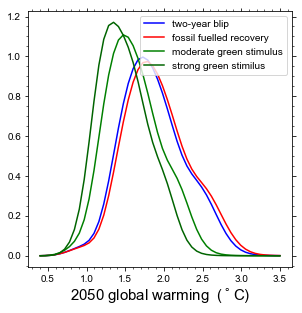

In [54]:
ic=3420
Cov22_2050=Cov22t_s[ic,:]
Covbase_2050=Covbaset_s[ic,:]
Cov3_2050=Cov3t_s[ic,:]
Cov13_2050=Cov13t_s[ic,:]
Cov4_2050=Cov4t_s[ic,:]
#pl.hist(Covbase_2050,weights=ks,alpha=0.3,label='baseline',bins=np.arange(.4,3.5,0.2),normed=True)
base2020 = st.gaussian_kde(Covbase_2050,weights=ks)
#pl.plot(np.linspace(.4,3.5), base2020(np.linspace(.4,3.5)),color='black',label='baseline')
#pl.hist(Cov22_2050,weights=ks,alpha=0.3,label='fossil fuelled rebound',color='red',bins=np.arange(.4,3.5,0.2),normed=True)

#pl.hist(Cov13_2050,weights=ks,alpha=0.3,label='green stimilus',color='green',bins=np.arange(.4,3.5,0.2),normed=True)
c32020 = st.gaussian_kde(Cov3_2050,weights=ks)
pl.plot(np.linspace(.4,3.5), c32020(np.linspace(.4,3.5)),color='blue',label='two-year blip')
c132020 = st.gaussian_kde(Cov13_2050,weights=ks)
c222020 = st.gaussian_kde(Cov22_2050,weights=ks)
pl.plot(np.linspace(.4,3.5), c222020(np.linspace(.4,3.5)),color='red',label='fossil fuelled recovery')
pl.plot(np.linspace(.4,3.5), c132020(np.linspace(.4,3.5)),color='green',label='moderate green stimulus')
#pl.hist(Cov3_2050,weights=ks,alpha=0.3,label='two-year blip',color='blue',bins=np.arange(.4,3.5,0.2),normed=True)

c42020 = st.gaussian_kde(Cov4_2050,weights=ks)
pl.plot(np.linspace(.4,3.5), c42020(np.linspace(.4,3.5)),color='darkgreen',label='strong green stimilus')
pl.legend()
pl.xlabel('2050 global warming  ($^\circ$C)',fontsize=15)

print(c42020.integrate_box_1d(0, 1.5))
print(c32020.integrate_box_1d(0, 1.5))
print(c132020.integrate_box_1d(0, 1.5))
print(c222020.integrate_box_1d(0, 1.5))

print(c42020.integrate_box_1d(0, 2))
print(c32020.integrate_box_1d(0, 2))
print(c132020.integrate_box_1d(0, 2))
print(c222020.integrate_box_1d(0, 2))

pl.savefig('FigS8.pdf')

In [46]:
dir(c32020)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_covariance',
 '_data_covariance',
 '_data_inv_cov',
 '_neff',
 '_norm_factor',
 '_weights',
 'covariance',
 'covariance_factor',
 'd',
 'dataset',
 'evaluate',
 'factor',
 'integrate_box',
 'integrate_box_1d',
 'integrate_gaussian',
 'integrate_kde',
 'inv_cov',
 'logpdf',
 'n',
 'neff',
 'pdf',
 'resample',
 'scotts_factor',
 'set_bandwidth',
 'silverman_factor',
 'weights']

In [47]:
#subsample the array to make an array I can then sample!
ni =[]
for i in range(samples):
    ni.append(np.argwhere(cks>=random.uniform(0, 1))[0][0])
#make differences

diff_cov22fw=Cov22f_s[3000:3500,:]-Covbasef_s[3000:3500,:]
diff_cov22tw=Cov22t_s[3000:3500,:]-Covbaset_s[3000:3500,:]
diff_cov13fw=Cov13f_s[3000:3500,:]-Covbasef_s[3000:3500,:]
diff_cov13tw=Cov13t_s[3000:3500,:]-Covbaset_s[3000:3500,:]
diff_cov3fw=Cov3f_s[3000:3500,:]-Covbasef_s[3000:3500,:]
diff_cov3tw=Cov3t_s[3000:3500,:]-Covbaset_s[3000:3500,:]
diff_cov4fw=Cov4f_s[3000:3421,:]-Covbasef_s[3000:3421,:]
diff_cov4tw=Cov4t_s[3000:3421,:]-Covbaset_s[3000:3421,:]


diff_cov22f=Cov22f_s[3000:3500,ni]-Covbasef_s[3000:3500,ni]
diff_cov22t=Cov22t_s[3000:3500,ni]-Covbaset_s[3000:3500,ni]
diff_cov13f=Cov13f_s[3000:3500,ni]-Covbasef_s[3000:3500,ni]
diff_cov13t=Cov13t_s[3000:3500,ni]-Covbaset_s[3000:3500,ni]
diff_cov3f=Cov3f_s[3000:3500,ni]-Covbasef_s[3000:3500,ni]
diff_cov3t=Cov3t_s[3000:3500,ni]-Covbaset_s[3000:3500,ni]
diff_cov4f=Cov4f_s[3000:3421,ni]-Covbasef_s[3000:3421,ni]
diff_cov4t=Cov4t_s[3000:3421,ni]-Covbaset_s[3000:3421,ni]

In [48]:
#errors

def err_min(diff):
    ans=diff.copy()
    for i in range(len(diff[:,0])):
        td=pd.DataFrame(columns=['Sample','T'])
        td['Sample'] =np.arange(len(diff[0,:]))
        td['T'] =diff[i,:]
        tdsort=td.sort_values('T',ignore_index=True)
        ans[i,:] =diff[i,tdsort['Sample']]
    return ans[:,np.int(0.05*len(diff[0,:]))]   

def err_max(diff):
    ans=diff.copy()
    for i in range(len(diff[:,0])):
        td=pd.DataFrame(columns=['Sample','T'])
        td['Sample'] =np.arange(len(diff[0,:]))
        td['T'] =diff[i,:]
        tdsort=td.sort_values('T',ignore_index=True)
        ans[i,:] =diff[i,tdsort['Sample']]
    return ans[:,np.int(0.95*len(diff[0,:]))]

NameError: name 'emissions_g1_4' is not defined

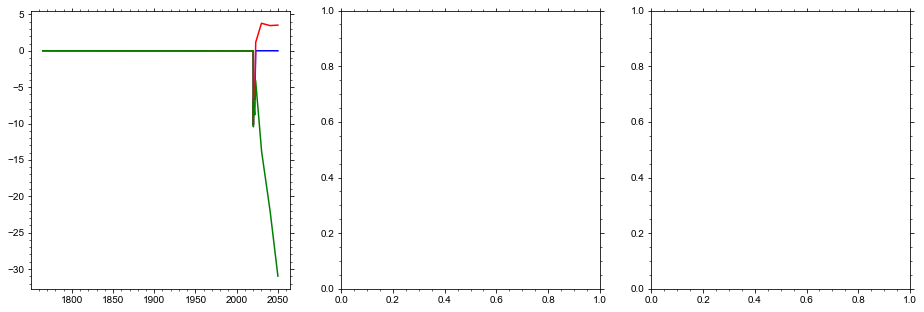

In [49]:
#plot difference from NDC

fig, ax = pl.subplots(1,3, figsize=(40/2.54, 13/2.54))

x=time[3000:3500]

#emission plot
x1=in_forcing.index
#ax[0].plot(x,emissions_g2_2[:,1]*3.67-emissions_base[:,1]*3.67,color='red',label='Total Aerosol')
#ax[0].plot(x,emissions_g1_3[:,1]*3.67-emissions_base[:,1]*3.67,color='green',label='Tropospheric ozone')
#ax[0].plot(x,emissions_g3[:,1]*3.67-emissions_base[:,1]*3.67,color='blue',label='Total')
ax[0].plot(x1,emissions_g3[:,1]*3.67-emissions_base[:,1]*3.67,color='blue',label='two-year blip')
ax[0].plot(x1,emissions_g2_2[:,1]*3.67-emissions_base[:,1]*3.67,color='red',label='fossil fuelled recovery')
ax[0].plot(x1,emissions_g1_3[:,1]*3.67-emissions_base[:,1]*3.67,color='green',label='moderate green stimulus')
ax[0].plot(x1,emissions_g4[:,1]*3.67-emissions_base[:,1]*3.67,color='darkgreen',label='strong green stimulus')
#ax[0].plot(x1,emissions_g3[:,1]*3.67-emissions_base[:,1]*3.67,color='blue',label='Two-year blip')
ax[0].legend(fontsize=15)

#ax[0].set_title('(a) CO2 emisisons',fontsize=15)
ax[0].set_xlim(2019,2030)
ax[0].set_ylim(-20,10)
ax[0].set_title(' a) CO$_2$ emissions cf baseline (GtCO$_2$)',fontsize=15)
#x=np.arange(350)+1750.0
#SSP460 forcing
ax[1].fill_between(x, err_min(diff_cov22f),err_max(diff_cov22f),facecolor='pink',alpha=0.2)
ax[1].plot(x, (diff_cov22fw[:,:]*ks).sum(axis=1), color='red',linewidth=2,label='Cov22')
ax[1].fill_between(x, err_min(diff_cov13f),err_max(diff_cov13f),facecolor='lightgreen',alpha=0.2)
ax[1].plot(x,(diff_cov13fw[:,:]*ks).sum(axis=1), color='green',linewidth=2,label='Cov13')
ax[1].fill_between(x, err_min(diff_cov3f),err_max(diff_cov3f),facecolor='lightblue',alpha=0.2)
ax[1].plot(x,(diff_cov3fw[:,:]*ks).sum(axis=1), color='blue',linewidth=2,label='Cov3')
ax[1].fill_between(x, err_min(diff_cov4f),err_max(diff_cov4f),facecolor='lightgreen',alpha=0.2)
ax[1].plot(x,(diff_cov4fw[:,:]*ks).sum(axis=1), color='darkgreen',linewidth=2,label='Cov4')

ax[1].set_title(' b) ERF cf baseline (W.m$^{-2}$)',fontsize=15)
ax[1].set_xlim(2019,2030)
ax[1].set_ylim(-0.15,.1)
#ax[1].set_ylabel('ERF, Wm-2',fontsize=15)

#SSP460 temp
ax[2].fill_between(x, err_min(diff_cov22t),err_max(diff_cov22t),facecolor='pink',alpha=0.2)
ax[2].plot(x, (diff_cov22tw[:,:]*ks).sum(axis=1), color='red',linewidth=2,label='Cov22')
ax[2].fill_between(x, err_min(diff_cov13t),err_max(diff_cov13t),facecolor='lightgreen',alpha=0.2)
ax[2].plot(x,(diff_cov13tw[:,:]*ks).sum(axis=1), color='green',linewidth=2,label='Cov13')
ax[2].fill_between(x, err_min(diff_cov3t),err_max(diff_cov3t),facecolor='lightblue',alpha=0.2)
ax[2].plot(x,(diff_cov3tw[:,:]*ks).sum(axis=1), color='blue',linewidth=2,label='Cov3')
ax[2].fill_between(x, err_min(diff_cov4t),err_max(diff_cov4t),facecolor='lightgreen',alpha=0.2)
ax[2].plot(x,(diff_cov4tw[:,:]*ks).sum(axis=1), color='darkgreen',linewidth=2,label='Cov4')

ax[2].set_title(' c) Temperature response cf baseline ($^\circ$C)',fontsize=15)
ax[2].set_xlim(2019,2030)
ax[2].set_ylim(-0.025,0.01)
#ax[2].set_ylabel('Temperature change relative to 1850-1900, K',fontsize=15)
pl.savefig('FigS7a.pdf')



In [ ]:
#plot difference from NDC

fig, ax = pl.subplots(1,3, figsize=(40/2.54, 13/2.54))

x=time[3000:3500]

#emission plot
x1=in_forcing.index
#ax[0].plot(x,emissions_g2_2[:,1]*3.67-emissions_base[:,1]*3.67,color='red',label='Total Aerosol')
#ax[0].plot(x,emissions_g1_3[:,1]*3.67-emissions_base[:,1]*3.67,color='green',label='Tropospheric ozone')
#ax[0].plot(x,emissions_g3[:,1]*3.67-emissions_base[:,1]*3.67,color='blue',label='Total')
ax[0].plot(x1,emissions_g3[:,1]*3.67-emissions_base[:,1]*3.67,color='blue',label='two-year blip')
ax[0].plot(x1,emissions_g2_2[:,1]*3.67-emissions_base[:,1]*3.67,color='red',label='fossil fuelled recovery')
ax[0].plot(x1,emissions_g1_3[:,1]*3.67-emissions_base[:,1]*3.67,color='green',label='moderate green stimulus')

ax[0].legend(fontsize=15)

#ax[0].set_title('(a) CO2 emisisons',fontsize=15)
ax[0].set_xlim(2019,2050)
ax[0].set_ylim(-40,10)
ax[0].set_title(' a) CO$_2$ emissions cf baseline (GtCO$_2$)',fontsize=15)
#x=np.arange(350)+1750.0
#SSP460 forcing
ax[1].fill_between(x, err_min(diff_cov22f),err_max(diff_cov22f),facecolor='pink',alpha=0.2)
ax[1].plot(x, (diff_cov22fw[:,:]*ks).sum(axis=1), color='red',linewidth=2,label='Cov22')
ax[1].fill_between(x, err_min(diff_cov13f),err_max(diff_cov13f),facecolor='lightgreen',alpha=0.2)
ax[1].plot(x,(diff_cov13fw[:,:]*ks).sum(axis=1), color='green',linewidth=2,label='Cov13')
ax[1].fill_between(x, err_min(diff_cov3f),err_max(diff_cov3f),facecolor='lightblue',alpha=0.2)
ax[1].plot(x,(diff_cov3fw[:,:]*ks).sum(axis=1), color='blue',linewidth=2,label='Cov3')
ax[1].fill_between(x, err_min(diff_cov4f),err_max(diff_cov4f),facecolor='lightgreen',alpha=0.2)
ax[1].plot(x,(diff_cov4fw[:,:]*ks).sum(axis=1), color='darkgreen',linewidth=2,label='Cov4')

ax[1].set_title(' b) ERF cf baseline (W.m$^{-2}$)',fontsize=15)
ax[1].set_xlim(2019,2040)
ax[1].set_ylim(-0.45,.2)
#ax[1].set_ylabel('ERF, Wm-2',fontsize=15)

#SSP460 temp
ax[2].fill_between(x, err_min(diff_cov22t),err_max(diff_cov22t),facecolor='pink',alpha=0.2)
ax[2].plot(x, (diff_cov22tw[:,:]*ks).sum(axis=1), color='red',linewidth=2,label='Cov22')
ax[2].fill_between(x, err_min(diff_cov13t),err_max(diff_cov13t),facecolor='lightgreen',alpha=0.2)
ax[2].plot(x,(diff_cov13tw[:,:]*ks).sum(axis=1), color='green',linewidth=2,label='Cov13')
ax[2].fill_between(x, err_min(diff_cov3t),err_max(diff_cov3t),facecolor='lightblue',alpha=0.2)
ax[2].plot(x,(diff_cov3tw[:,:]*ks).sum(axis=1), color='blue',linewidth=2,label='Cov3')
ax[2].fill_between(x, err_min(diff_cov4t),err_max(diff_cov4t),facecolor='lightgreen',alpha=0.2)
ax[2].plot(x,(diff_cov4tw[:,:]*ks).sum(axis=1), color='darkgreen',linewidth=2,label='Cov4')

ax[2].set_title(' c) Temperature response cf baseline ($^\circ$C)',fontsize=15)
ax[2].set_xlim(2019,2050)
ax[2].set_ylim(-0.3,0.1)
#ax[2].set_ylabel('Temperature change relative to 1850-1900, K',fontsize=15)

pl.savefig('FigS7b.pdf')

In [ ]:
14/50